In [1]:
import os
import random

import pickle
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

custom_seed = 42
np.random.seed(custom_seed)
tf.random.set_seed(custom_seed)

In [2]:
n_data = int(1e4)
n_discretization = 10

x_0 = y_0 = 0
x_L = y_L = 1

x = np.linspace(x_0, x_L, n_discretization).astype(np.float32)
x_step_size = (x_L - x_0) / (n_discretization - x_L)

y = np.linspace(y_0, y_L, n_discretization).astype(np.float32)
y_step_size = (y_L - y_0) / (n_discretization - y_L)

X_mesh, Y_mesh = np.meshgrid(x, y)

In [3]:
# Finite difference convolutional operator to derivate in x axis
def Dx(f, x_step_size=x_step_size):
    Dx = tf.constant([[-1, +1], 
                      [-1, +1]], 
                     dtype=tf.float32)/(2*x_step_size)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Dx = tf.expand_dims(tf.expand_dims(Dx, axis=-1), axis=-1)
    dfdx = tf.nn.conv2d(f_reshaped, Dx, strides=[1, 1, 1, 1], padding='VALID', name='dfdx')
    return tf.squeeze(dfdx, axis=-1)

# Finite difference convolutional operator to derivate in y axis
def Dy(f, y_step_size=y_step_size):
    Dy = tf.constant([[+1, +1], 
                      [-1, -1]],  
                     dtype=tf.float32)/(-2*y_step_size)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Dy = tf.expand_dims(tf.expand_dims(Dy, axis=-1), axis=-1)
    dfdy = tf.nn.conv2d(f_reshaped, Dy, strides=[1, 1, 1, 1], padding='VALID', name='dfdy')
    return tf.squeeze(dfdy, axis=-1)

# Convolutional operator to do the mean between two elements of a mesh in x axis
def Mx(f):
    Mx = tf.constant([[+1, +1]], 
                     dtype=tf.float32)/(2)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Mx = tf.expand_dims(tf.expand_dims(Mx, axis=-1), axis=-1)
    x_avg = tf.nn.conv2d(f_reshaped, Mx, strides=[1, 1, 1, 1], padding='VALID', name='Mx')
    return tf.squeeze(x_avg, axis=-1)

# Convolutional operator to do the mean between two elements of a mesh in y axis
def My(f):
    My = tf.constant([[+1], 
                      [+1]], 
                     dtype=tf.float32)/(2)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    My = tf.expand_dims(tf.expand_dims(My, axis=-1), axis=-1)
    y_avg = tf.nn.conv2d(f_reshaped, My, strides=[1, 1, 1, 1], padding='VALID', name='My')
    return tf.squeeze(y_avg, axis=-1)

In [4]:
def cm_to_in(cm):
    return cm * 0.393701

def relative_error(validation, prediction):
    return np.sqrt((np.trapz(np.trapz((validation - prediction)**2))/np.trapz(np.trapz((validation)**2))))

In [5]:
linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10) 
posY = cm_to_in(10) 
width = cm_to_in(16)
height = cm_to_in(8) 

color = [0.1, 0, 0.8]  
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

In [6]:
def plot_boxplot_and_colormaps(validation_solution, predicted_solution, variable, problem):

    # Parameters for the graphics
    colors = sns.color_palette("hls", 8)
    
    # Computing relative error and boxplots values
    solution_error = relative_error(validation=validation_solution, prediction=predicted_solution)
    min = np.percentile(solution_error, 5)
    max = np.percentile(solution_error, 95)  
    min_index = np.argmin(np.abs(solution_error - min))
    max_index = np.argmin(np.abs(solution_error - max))

    # Boxplot code 
    plt.figure(figsize=(width/1.5, 2*height))

    sns.boxplot(y=solution_error, color=colors[4], width=0.4)  
    plt.scatter(x=0, y=solution_error[min_index], color=colors[0], edgecolor='black', label='P5', zorder=4)
    plt.scatter(x=0, y=solution_error[max_index], color=colors[1], edgecolor='black', label='P95', zorder=4)
    sns.stripplot(y=solution_error, color=colors[5], jitter=0.1, size=3, alpha=0.4, edgecolor='black', linewidth=0.11)

    plt.xlim(-0.5, 0.5)
    plt.ylabel('$E_r$', fontsize=label_fontsize)
    plt.yscale('log')
    plt.legend(loc='upper left', fontsize=legend_fontsize)
    plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    plt.savefig(fr"C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\Figures\Appendices\{variable}_{problem}_boxplot.png", format='png', dpi=1200, bbox_inches='tight')
    plt.show()

    # Minimum error plot
    combined_data = np.concatenate((validation_solution[min_index].numpy().flatten(), predicted_solution[min_index].numpy().flatten()))
    vmin = np.min(combined_data)
    vmax = np.max(combined_data)

    fig, axs = plt.subplots(1, 2, figsize=(width, height), gridspec_kw={'wspace': 0.4})
    plt.subplots_adjust(left=subplot_adjust_left, bottom=subplot_adjust_bottom)  

    im1 = axs[0].imshow(validation_solution[min_index], cmap='viridis', interpolation='bicubic', vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
    plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    im2 = axs[1].imshow(predicted_solution[min_index], cmap='viridis', interpolation='bicubic', vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
    plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
        ax.set_xticks(np.arange(0, 1.1, 0.2))
        ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.tick_params(axis='x', labelsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)

    plt.savefig(fr"C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\Figures\Appendices\{variable}_{problem}_min.pdf", format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()

    # Maximum error plot
    combined_data = np.concatenate((validation_solution[max_index].numpy().flatten(), predicted_solution[max_index].numpy().flatten()))
    vmin = np.min(combined_data)
    vmax = np.max(combined_data)

    fig, axs = plt.subplots(1, 2, figsize=(width, height), gridspec_kw={'wspace': 0.4})
    plt.subplots_adjust(left=subplot_adjust_left, bottom=subplot_adjust_bottom)  

    im1 = axs[0].imshow(validation_solution[max_index], cmap='viridis', interpolation='bicubic', vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
    plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    im2 = axs[1].imshow(predicted_solution[max_index], cmap='viridis', interpolation='bicubic', vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
    plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
        ax.set_xticks(np.arange(0, 1.1, 0.2))
        ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.tick_params(axis='x', labelsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)

    plt.savefig(fr"C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\Figures\Appendices\{variable}_{problem}_max.pdf", format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()

In [7]:
def plot_each_variable_boxplot(problem):

    data_folder = r'C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\data'
    results_folder = rf'C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\results\{problem}_results'

    data_path = os.path.join(data_folder, f'{problem}_data.pkl')
    second_training_result_path = os.path.join(results_folder, f'{problem}_new_train.pkl')
    print(data_folder)
    print(results_folder)

    # Load data
    with open(data_path, 'rb') as f:
        data = pickle.load(f)

    # Load training results
    with open(second_training_result_path, 'rb') as f:
        results_second_train_pkl = pickle.load(f)
    predictions_predictive_second_train = results_second_train_pkl['predictions_pred']
    predictions_explanatory_second_train = results_second_train_pkl['predictions_exp']

    # Solution
    print("u")
    validation_solution = tf.convert_to_tensor(data['y_val'], dtype=tf.float32)
    predicted_solution = tf.convert_to_tensor(predictions_predictive_second_train, dtype=tf.float32)
    plot_boxplot_and_colormaps(validation_solution=validation_solution, predicted_solution=predicted_solution, variable='u', problem=problem)

    # Diffusivity
    print("K")
    validation_K = tf.convert_to_tensor(My(Mx(tf.convert_to_tensor(data['k_val'], dtype=tf.float32))), dtype=tf.float32)
    predicted_K = tf.convert_to_tensor(predictions_explanatory_second_train, dtype=tf.float32)
    if len(predicted_K.shape) == 2:
        predicted_K = tf.tile(tf.expand_dims(predicted_K, axis=0), [tf.shape(validation_K)[0], 1, 1])
    plot_boxplot_and_colormaps(validation_solution=validation_K, predicted_solution=predicted_K, variable='K', problem=problem)

    # Flux along x direction
    print("qx")
    validation_qx = tf.convert_to_tensor(My(Mx(tf.convert_to_tensor(data['qx_val'], dtype=tf.float32))), dtype=tf.float32)
    predicted_qx = tf.convert_to_tensor(predicted_K*Dx(predictions_predictive_second_train), dtype=tf.float32)
    plot_boxplot_and_colormaps(validation_solution=validation_qx, predicted_solution=predicted_qx, variable='qx', problem=problem)

    # Flux along y direction
    print("qy")
    validation_qy = tf.convert_to_tensor(My(Mx(tf.convert_to_tensor(data['qy_val'], dtype=tf.float32))), dtype=tf.float32)
    predicted_qy = tf.convert_to_tensor(predicted_K*Dy(predictions_predictive_second_train), dtype=tf.float32)
    plot_boxplot_and_colormaps(validation_solution=validation_qy, predicted_solution=predicted_qy, variable='qy', problem=problem)

In [8]:
def plot_each_variable_boxplot_tensorial(problem):

    data_folder = r'C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\data'
    results_folder = rf'C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\results\{problem}_results'

    data_path = os.path.join(data_folder, f'{problem}_data.pkl')
    second_training_result_path = os.path.join(results_folder, f'{problem}_new_train.pkl')
    print(data_folder)
    print(results_folder)

    # Load data
    with open(data_path, 'rb') as f:
        data = pickle.load(f)

    # Load training results
    with open(second_training_result_path, 'rb') as f:
        results_second_train_pkl = pickle.load(f)
    predictions_predictive_second_train = results_second_train_pkl['predictions_pred']
    predictions_explanatory_second_train = results_second_train_pkl['predictions_exp']
    
    # Solution
    print("u")
    validation_solution = tf.convert_to_tensor(data['y_val'], dtype=tf.float32)
    predicted_solution = tf.convert_to_tensor(predictions_predictive_second_train, dtype=tf.float32)
    plot_boxplot_and_colormaps(validation_solution=validation_solution, predicted_solution=predicted_solution, variable='u', problem=problem)

    # The three components of diffusivity
    print("Kxx")
    validation_K = tf.convert_to_tensor(My(Mx(tf.convert_to_tensor(data['k_val'], dtype=tf.float32))), dtype=tf.float32)[:, 0]
    predicted_K = tf.convert_to_tensor(predictions_explanatory_second_train, dtype=tf.float32)[0]
    if len(predicted_K.shape) == 2:
        predicted_K = tf.tile(tf.expand_dims(predicted_K, axis=0), [tf.shape(validation_K)[0], 1, 1])
    plot_boxplot_and_colormaps(validation_solution=validation_K, predicted_solution=predicted_K, variable='K_xx', problem=problem)

    print("Kxy")
    validation_K = tf.convert_to_tensor(My(Mx(tf.convert_to_tensor(data['k_val'], dtype=tf.float32))), dtype=tf.float32)[:, 1]
    predicted_K = tf.convert_to_tensor(predictions_explanatory_second_train, dtype=tf.float32)[1]
    if len(predicted_K.shape) == 2: 
        predicted_K = tf.tile(tf.expand_dims(predicted_K, axis=0), [tf.shape(validation_K)[0], 1, 1])
    plot_boxplot_and_colormaps(validation_solution=validation_K, predicted_solution=predicted_K, variable='K_xy', problem=problem)

    print("Kyy")
    validation_K = tf.convert_to_tensor(My(Mx(tf.convert_to_tensor(data['k_val'], dtype=tf.float32))), dtype=tf.float32)[:, 3]
    predicted_K = tf.convert_to_tensor(predictions_explanatory_second_train, dtype=tf.float32)[3]
    if len(predicted_K.shape) == 2:
        predicted_K = tf.tile(tf.expand_dims(predicted_K, axis=0), [tf.shape(validation_K)[0], 1, 1])
    plot_boxplot_and_colormaps(validation_solution=validation_K, predicted_solution=predicted_K, variable='K_yy', problem=problem)

    predicted_K = tf.convert_to_tensor(predictions_explanatory_second_train, dtype=tf.float32)
    
    # Flux along x direction
    print("qx")
    validation_qx = tf.convert_to_tensor(My(Mx(tf.convert_to_tensor(data['qx_val'], dtype=tf.float32))), dtype=tf.float32)
    predicted_qx = predicted_K[0]*Dx(predictions_predictive_second_train) + predicted_K[1]*Dx(predictions_predictive_second_train)
    plot_boxplot_and_colormaps(validation_solution=validation_qx, predicted_solution=predicted_qx, variable='qx', problem=problem)
    
    # Flux along y direction
    print("qy")
    validation_qy = tf.convert_to_tensor(My(Mx(tf.convert_to_tensor(data['qy_val'], dtype=tf.float32))), dtype=tf.float32)
    predicted_qy = predicted_K[1]*Dy(predictions_predictive_second_train).numpy() + predicted_K[3]*Dy(predictions_predictive_second_train).numpy()
    plot_boxplot_and_colormaps(validation_solution=validation_qy, predicted_solution=predicted_qy, variable='qy', problem=problem)

Nonlinear_problem_P4
C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\data
C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\results\nonlinear_problem_P4_results
u


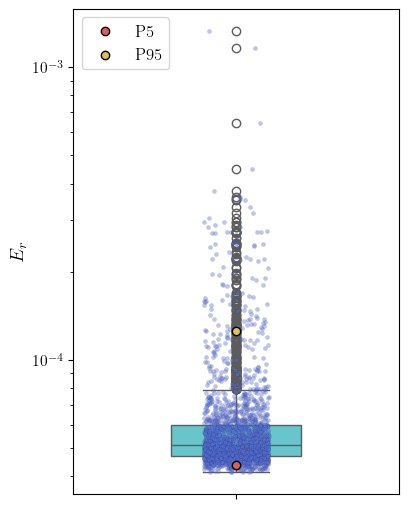

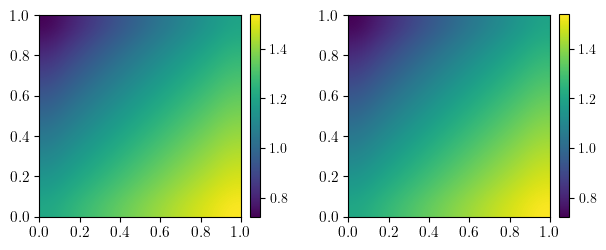

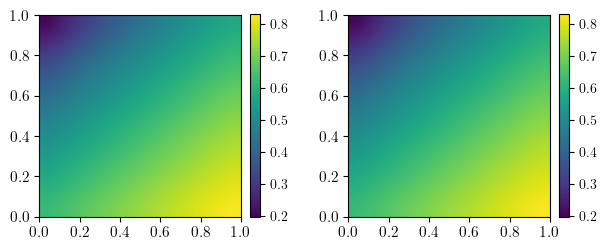

K


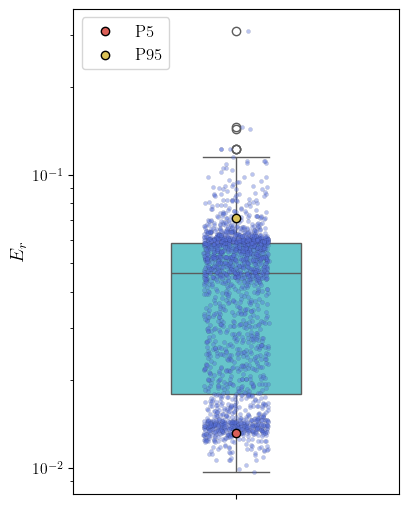

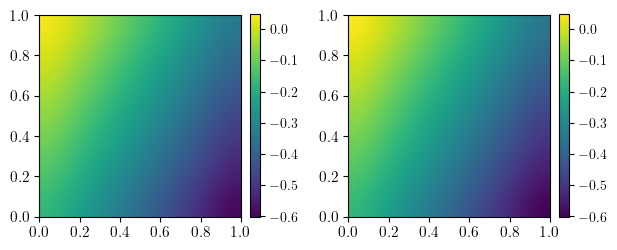

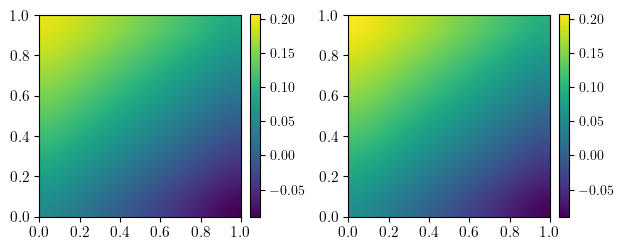

qx


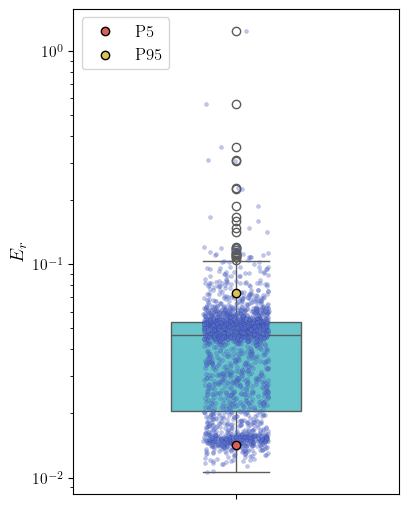

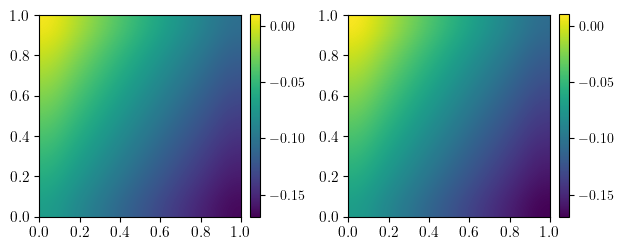

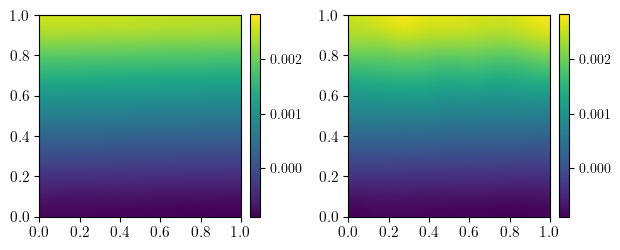

qy


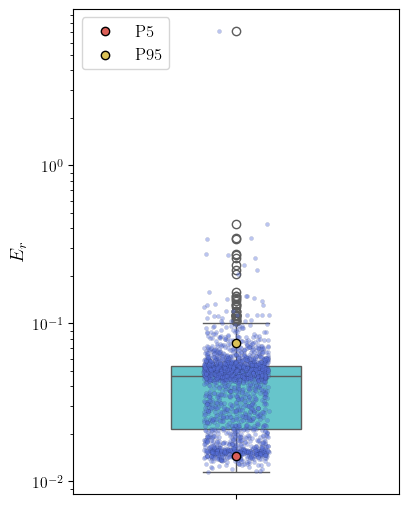

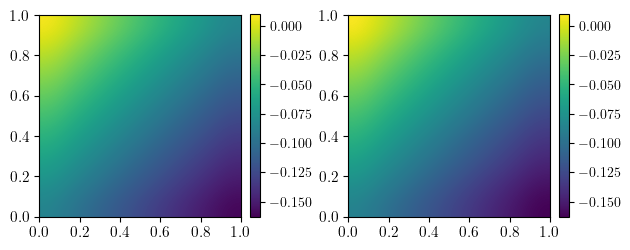

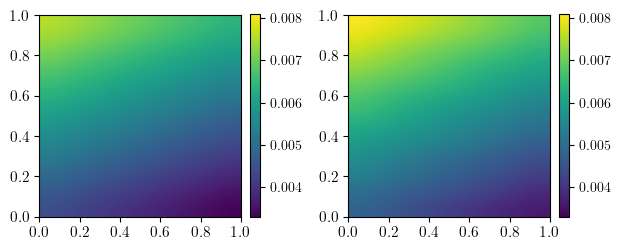

In [ ]:
print("Heterogeneous_problem")
plot_each_variable_boxplot(problem="heterogeneous_problem")

print("Tensorial_problem")
plot_each_variable_boxplot_tensorial(problem="tensorial_problem")

print("Nonlinear_problem_P3")
plot_each_variable_boxplot(problem="nonlinear_problem_P3")

print("Nonlinear_problem_P4")
plot_each_variable_boxplot(problem="nonlinear_problem_P4")